In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from bdshare import get_hist_data #library for extracting stock data from DSE and CSE 

In [2]:
stock_data = get_hist_data('2021-04-11','2022-10-17','MARICO') # data after 2022-10-30 has not been updated 
pd.set_option('display.max_rows', None)
print(stock_data.to_string())

            symbol     ltp    high     low    open   close     ycp trade    value volume
date                                                                                    
2022-10-17  MARICO  2421.5    2422  2421.5    2422  2421.5  2422.2    48    1.053    435
2022-10-16  MARICO  2422.2    2429  2421.5    2425  2422.2    2425    84    4.078   1684
2022-10-13  MARICO    2425    2436  2422.5    2430    2425  2424.5    70    6.526   2691
2022-10-12  MARICO  2424.5    2434  2422.2    2434  2424.5  2432.4   155    5.571   2298
2022-10-11  MARICO    2425    2440    2424    2428  2432.4  2427.1    55    1.603    660
2022-10-10  MARICO  2427.1  2439.9    2426  2431.5  2427.1  2431.5    38    0.991    408
2022-10-06  MARICO  2431.5    2440  2431.1  2431.1  2431.5    2434    61    1.421    584
2022-10-04  MARICO    2434    2440    2431    2434    2434  2432.9    26    0.511    210
2022-10-03  MARICO  2432.9    2440  2432.2    2440  2432.9  2436.1    29    0.526    216
2022-10-02  MARICO   

In [3]:
#convert the closing prices to float 
stock = stock_data['close'].astype(float)

In [4]:
#convert the index to datetime
date = pd.to_datetime(stock_data.index)

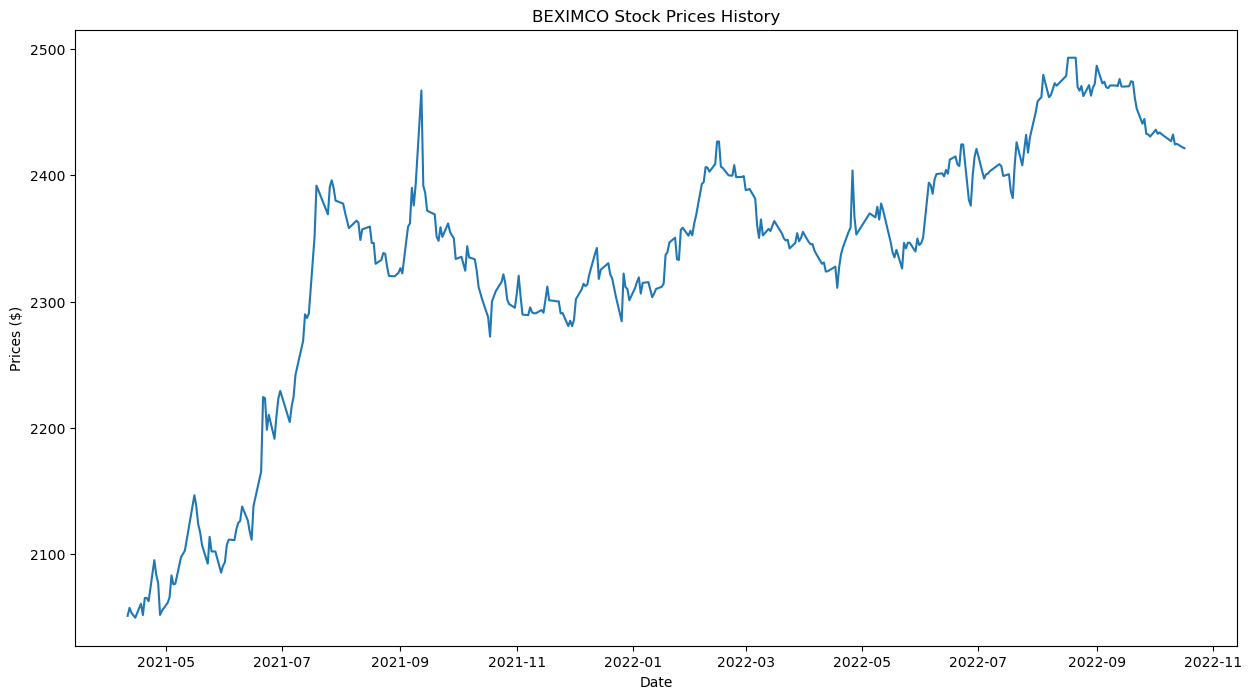

In [5]:
#plot the timeseries for Marico stock price
plt.figure(figsize=(15, 8))
plt.title('BEXIMCO Stock Prices History')
plt.plot(date, stock)
plt.xlabel('Date')
plt.ylabel('Prices ($)')
#plt.xticks(rotation=45)
#plt.yticks(rotation = 45)
plt.show()

In [6]:
close_prices = stock
values = np.flip(close_prices.values, axis = 0) #there are 380 datapoints in total arranged from 2021 to 2022 
training_data_len = math.ceil(len(values)* 0.8) #will be taking 80% of the dataset (304 datapoints) 

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(values.reshape(-1,1))

In [7]:
train_data = scaled_data[0: training_data_len, :]#extracting the first 304 datapoints 

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #contains the first 244 datapoints (304-60)
    y_train.append(train_data[i, 0]) #contains the last 244 datapoints 
    #we observe the first 3 months to predict the next 3 months(60 points) 
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # reshaped to dim(240,60,1) 
#(240: our sample size, 60 timesteps: we want the model to look back 60 timesteps to predict the next 60, 
#features: the timesteps are taken from 1 ts data, if we wanted to include the historic data of other 
#ts plots we would increase the features accordingly)

In [8]:
test_data = scaled_data[training_data_len-60: , : ] #contains 136 datapoints 
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0]) #contains 76 datapoints (136-60)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(20))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 123,241
Trainable params: 123,241
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
232/232 [==============================] - 5s 13ms/step - loss: 0.0112
Epoch 2/3
232/232 [==============================] - 3s 13ms/step - loss: 0.0042
Epoch 3/3
232/232 [==============================] - 3s 13ms/step - loss: 0.0034


In [11]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 1s 13ms/step


11.645345943921233

In [12]:
data = pd.DataFrame(stock_data.loc[:, 'close'].iloc[::-1]) #need to flip the dataframe and arrange from 2021 to 2022
#data = stock_data.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions

C:\Users\Mir Info\AppData\Local\Temp\ipykernel_12792\403298629.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


C:\Users\Mir Info\AppData\Local\Temp\ipykernel_12792\673696052.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['close'] = validation['close'].astype(float)
C:\Users\Mir Info\AppData\Local\Temp\ipykernel_12792\673696052.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = validation['predictions'].astype(float)


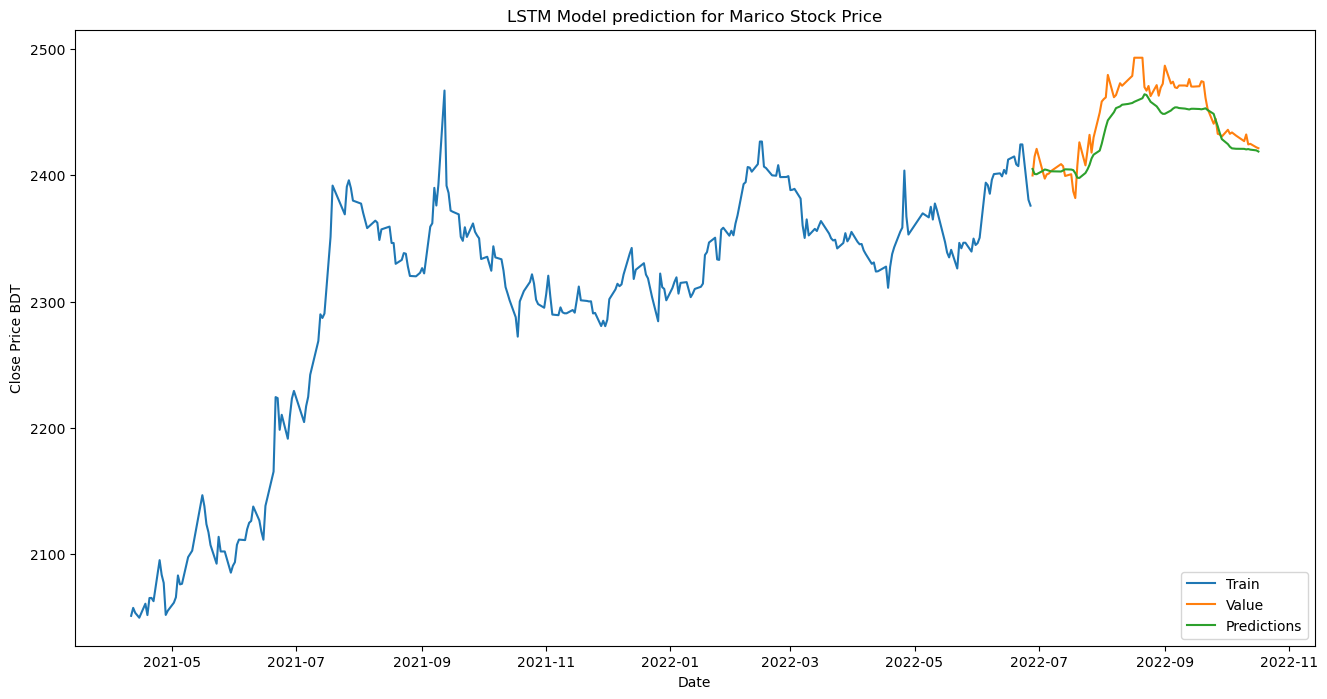

In [15]:
plt.figure(figsize=(16,8))
plt.title('LSTM Model prediction for Marico Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price BDT')

#convert the closing prices to float 
trainstock = train['close'].astype(float)
#convert the index to datetime 
traindate = pd.to_datetime(train.index)
plt.plot(traindate, trainstock)

validdate = pd.to_datetime(validation.index)
close = validation['close'].astype(float)
pred = validation['predictions'].astype(float)
validation['close'] = validation['close'].astype(float)
validation['predictions'] = validation['predictions'].astype(float)
plt.plot(validdate, validation[['close', 'predictions']])
plt.legend(['Train', 'Value', 'Predictions'], loc='lower right')
plt.show()

In [14]:
pd.set_option('display.max_rows', None)
print(validation)

             close  predictions
date                           
2022-06-28  2399.9  2405.033936
2022-06-29  2414.9  2401.043701
2022-06-30  2421.0  2400.915283
2022-07-03  2403.1  2403.508789
2022-07-04  2397.4  2404.659668
2022-07-05  2400.8  2404.292480
2022-07-06  2401.4  2403.723633
2022-07-07  2403.3  2403.201416
2022-07-12  2408.9  2403.045410
2022-07-13  2407.3  2403.854980
2022-07-14  2399.5  2404.787842
2022-07-17  2400.9  2404.608643
2022-07-18  2387.3  2404.144043
2022-07-19  2382.0  2401.756104
2022-07-20  2407.6  2398.144775
2022-07-21  2426.2  2397.946533
2022-07-24  2407.9  2401.858887
2022-07-25  2419.7  2404.693604
2022-07-26  2432.1  2408.311035
2022-07-27  2418.0  2413.377441
2022-07-28  2430.1  2416.382324
2022-07-31  2449.7  2419.613281
2022-08-01  2458.5  2425.010742
2022-08-02  2460.4  2431.696045
2022-08-03  2461.8  2438.145996
2022-08-04  2479.6  2443.582764
2022-08-07  2461.9  2450.033447
2022-08-08  2463.6  2453.258057
2022-08-10  2473.0  2454.608887
2022-08-